# Creating the Initial Conditions
First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd 
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [2]:
# define the input directory
input_dir = os.getcwd()

## Constructing the Initial Conditions
For my model, I will use data taken from NERRS (National Estuarine Research Reserve System) and interpolate that onto my model grid using data from 4 water stations in the Elkhorn slough. I will prepare the initial condition fields in 7 steps:
1. download NERRS data
2. read the model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the NERRS fields for interpolation
5. interpolate the NERRS fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my initial condition approach

### Step 1: Download the NERRS fields
To begin, I downloaded the water quality and weather data from NERRS. These fields are available [HERE](https://cdmo.baruch.sc.edu/aqs/chooseYearsCustomWaterMet.cfm). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (September 2025):

I stored these fields in the same directory as this notebook:

In [3]:
data_folder = os.getcwd()

In [4]:
#import Elkhorn Slough station files
station_file = "station_file.csv"
stations = pd.read_csv(station_file)
station_meta = pd.DataFrame({
    "StationCode": ["elkcwmet", "elkapwq", "elknmwq", "elksmwq", "elkvmwq"],
    "lon": [-121.738, -121.754, -121.738, -121.739, -121.779],
    "lat": [ 36.815,   36.846,   36.835,   36.818,   36.811],
})

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [5]:
# define the parameters that will be used in the data file
x_min, x_max = -121.795, -121.739
y_min, y_max =  36.80,    36.861

delX = 0.00015556
delY = 0.00025417
xgOrigin = -121.795
ygOrigin = 36.8
n_rows = 240
n_cols = 360

# recreate the grids that will be used in the model
xc = np.arange(x_min + delX/2, x_max + delX/2, delX)  # lon centers
yc = np.arange(y_min + delY/2, y_max + delY/2, delY)  # lat centers
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'slough_bathymetry.bin'),'>f4').reshape(np.shape(XC))

With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [6]:
delR = np.array([1, 2, 3, 4, 5])  # 5 layers (total 15 m depth)

In [7]:
def create_hFacC_grid(bathy, delR):
    """
    Recreate hFacC array (k, j, i) showing fraction of each vertical layer that is open water.
    bathy: 2D array of depth (positive down)
    delR:  1D array of layer thicknesses
    """
    ny, nx = bathy.shape
    nz = len(delR)
    hFacC = np.zeros((nz, ny, nx))

    for k in range(nz):
        z_bottom = np.sum(delR[:k+1])
        z_top = np.sum(delR[:k])
        layer_thickness = delR[k]

        # where bathy > z_bottom → full cell
        # where z_top < bathy < z_bottom → partial cell
        # where bathy <= z_top → land
        full = bathy >= z_bottom
        partial = (bathy > z_top) & (bathy < z_bottom)

        hFacC[k, full] = 1.0
        hFacC[k, partial] = (bathy[partial] - z_top) / layer_thickness

    return hFacC


In [8]:
depth = bathy   # make sure bathy is positive down
hFacC = create_hFacC_grid(depth, delR)

mask = np.copy(hFacC)
mask[mask > 0] = 1

C:\Users\rilee\miniconda3\envs\ms274\Lib\site-packages\matplotlib\colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


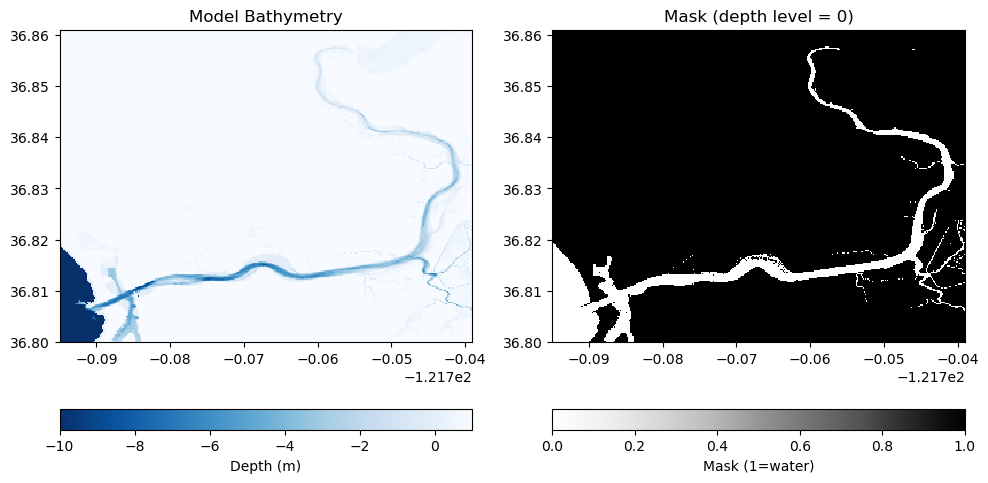

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, depth, vmin=-10, vmax=1, cmap='Blues_r')
plt.colorbar(C, orientation='horizontal', label='Depth (m)')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[depth_level], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation='horizontal', label='Mask (1=water)')
plt.title(f'Mask (depth level = {depth_level})')

plt.tight_layout()
plt.show()


### Step 4: Interpolate the Fields onto the Model Grid
Next, I will interpolate the NERRS external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [10]:
def norm_key(s):
    return str(s).strip().casefold()

# build maps from normalized code -> lon/lat
lon_map = dict(zip(station_meta["StationCode"].map(norm_key), station_meta["lon"]))
lat_map = dict(zip(station_meta["StationCode"].map(norm_key), station_meta["lat"]))

# add a normalized key column to stations
stations = stations.copy()
stations["__key"] = stations["StationCode"].map(norm_key)

# attach lon/lat via map (no merge, no suffixes)
stations["lon"] = stations["__key"].map(lon_map)
stations["lat"] = stations["__key"].map(lat_map)

# quick check: which station codes didn’t get coords?
missing = stations.loc[stations["lon"].isna() | stations["lat"].isna(), "StationCode"].dropna().unique()
print("Missing coord matches:", list(missing))

Missing coord matches: []


In [11]:
# make sure time + variable names are right
stations["DateTimeStamp"] = pd.to_datetime(stations["DateTimeStamp"], errors="coerce")

# if your file uses DO_mgl, rename once so we just use "DO"
if "DO_mgl" in stations.columns and "DO" not in stations.columns:
    stations = stations.rename(columns={"DO_mgl": "DO"})

# filter to Oct 2024
oct_mask = (stations["DateTimeStamp"] >= "2024-10-01") & (stations["DateTimeStamp"] <= "2024-10-31")
oct_df = stations.loc[oct_mask, ["StationCode","lon","lat","Temp","Sal","DO"]].copy()

# ensure numeric
for c in ["lon","lat","Temp","Sal","DO"]:
    oct_df[c] = pd.to_numeric(oct_df[c], errors="coerce")

# per-station mean (this is what we’ll interpolate)
oct_mean = (oct_df
            .groupby("StationCode")[["lon","lat","Temp","Sal","DO"]]
            .mean()
            .reset_index())

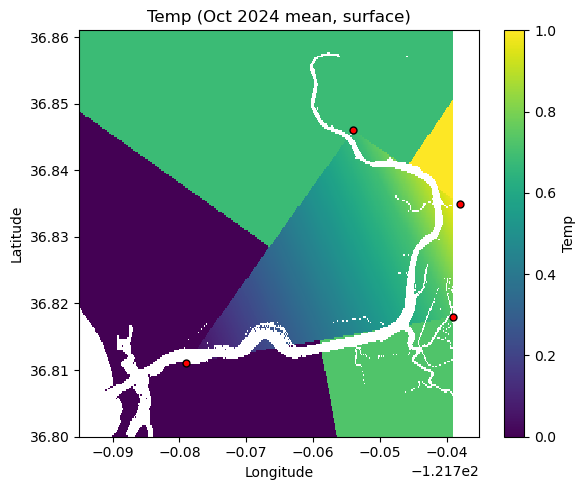

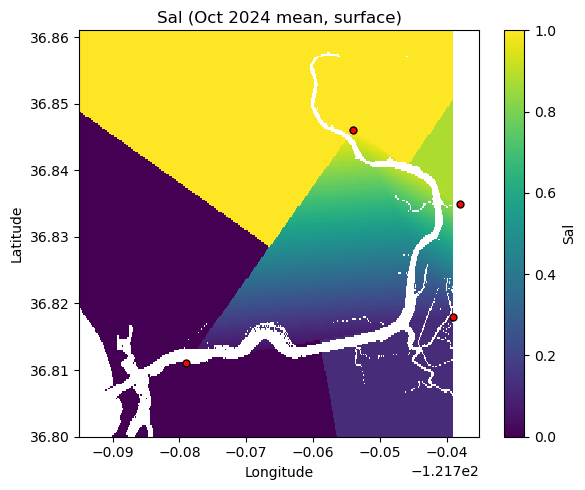

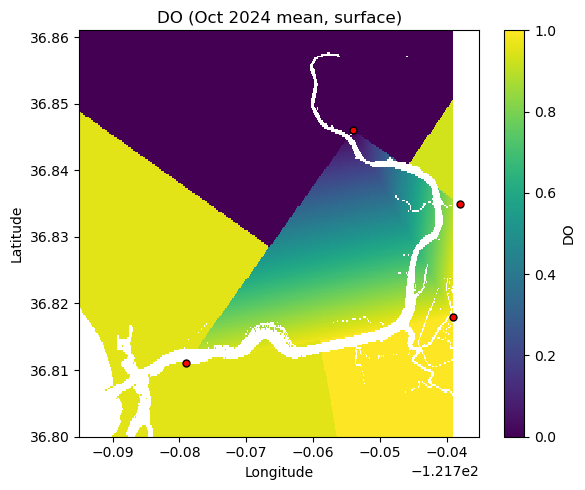

In [12]:
nz = hFacC.shape[0]
vars_to_do = ["Temp","Sal","DO"]
fields_3d = {}

pts_all = oct_mean[["lon","lat"]].to_numpy(float)

for var in vars_to_do:
    vals_all = oct_mean[var].to_numpy(float)
    m = np.isfinite(pts_all[:,0]) & np.isfinite(pts_all[:,1]) & np.isfinite(vals_all)
    pts, vals = pts_all[m], vals_all[m]

    fld2d = griddata(pts, vals, (XC, YC), method="linear")
    nan_mask = np.isnan(fld2d)
    if np.any(nan_mask):
        fld2d[nan_mask] = griddata(pts, vals, (XC[nan_mask], YC[nan_mask]), method="nearest")

    fld3d = np.tile(fld2d, (nz, 1, 1))
    fld3d[hFacC == 0] = np.nan
    fields_3d[var] = fld3d

    # surface plot
    surf = fld3d[0].copy()
    surf[hFacC[0] == 0] = np.nan
    plt.figure(figsize=(6,5))
    plt.pcolormesh(XC, YC, surf, shading="auto", cmap="viridis")
    plt.scatter(pts[:,0], pts[:,1], s=25, c="r", edgecolor="k")
    plt.colorbar(label=var)
    plt.title(f"{var} (Oct 2024 mean, surface)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()


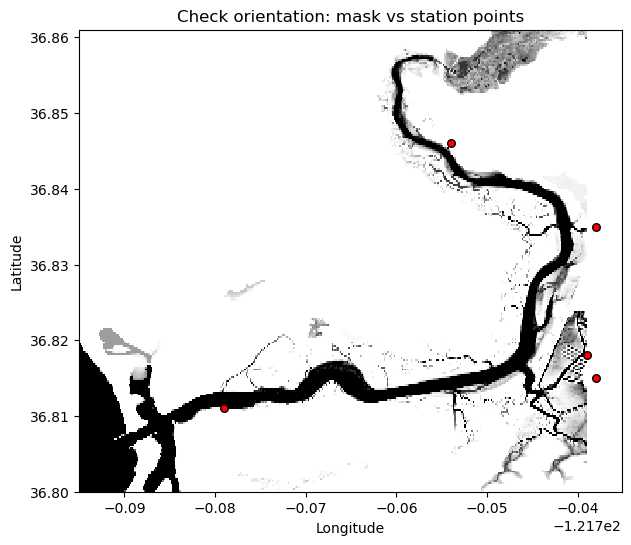

In [13]:
#troubleshooting, see where stations lie on mask
plt.figure(figsize=(7,6))
plt.pcolormesh(XC, YC, hFacC[0], cmap="Greys_r")
plt.scatter(oct_mean["lon"], oct_mean["lat"], c='r', edgecolor='k', s=30)
plt.title("Check orientation: mask vs station points")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()


In [14]:
# troubleshooting
#use nearest grid point to see if each station is in water
def is_in_water(lon, lat):
    j = np.abs(YC[:,0] - lat).argmin()
    i = np.abs(XC[0,:] - lon).argmin()
    return hFacC[0,j,i] > 0

mask_water = [is_in_water(lon, lat) for lon, lat in zip(oct_mean["lon"], oct_mean["lat"])]
oct_mean_water = oct_mean.loc[mask_water].copy()
print("Stations used:", oct_mean_water["StationCode"].tolist())


Stations used: ['elkapwq   ', 'elkcwmet  ', 'elknmwq   ', 'elksmwq   ', 'elkvmwq   ']


### Step 6: Plotting the Initial Condition Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

### Step 7: Run-time considerations
To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to `PARM05` of the data file:

```
#class example, change to fit the Elkhorn Slough model
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```